Tushar Kumar 23B2450

# Data Collection

In [40]:
import pandas as pd
import yfinance as yf

# Stock price data for Tesla from Yahoo Finance for the past 2 years
ticker = 'TSLA'
data = yf.download(ticker, start='2021-01-01', end='2023-01-01')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2021-01-04,243.256668,248.163330,239.063339,239.820007,145914600
2021-01-05,245.036667,246.946671,239.733337,241.220001,96735600
2021-01-06,251.993332,258.000000,249.699997,252.830002,134100000
2021-01-07,272.013336,272.329987,258.399994,259.209991,154496700
2021-01-08,293.339996,294.829987,279.463318,285.333344,225166500


# Preprocessing the Data

In [2]:
data.info()

# Handling any missing values
data = data.dropna()
data_monthly = data.resample('M').mean()

# Spliting the data
train_size = int(len(data_monthly) * 0.8)
train, test = data_monthly[:train_size], data_monthly[train_size:]
train.head(), test.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-01-04 to 2022-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   503 non-null    float64
 1   (High, TSLA)    503 non-null    float64
 2   (Low, TSLA)     503 non-null    float64
 3   (Open, TSLA)    503 non-null    float64
 4   (Volume, TSLA)  503 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 23.6 KB


C:\Users\valra\AppData\Local\Temp\ipykernel_7640\1870902260.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data.resample('M').mean()


(Price            Close        High         Low        Open        Volume
 Ticker            TSLA        TSLA        TSLA        TSLA          TSLA
 Date                                                                    
 2021-01-31  276.258947  281.719997  270.357716  275.725791  1.114255e+08
 2021-02-28  264.756491  270.785787  258.041054  265.857542  8.255651e+07
 2021-03-31  218.934202  225.836812  211.452174  220.130724  1.229286e+08
 2021-04-30  236.539365  241.251747  231.734762  236.427620  9.693424e+07
 2021-05-31  205.584335  210.278999  201.465501  206.239336  9.377637e+07,
 Price            Close        High         Low        Open        Volume
 Ticker            TSLA        TSLA        TSLA        TSLA          TSLA
 Date                                                                    
 2022-08-31  294.869857  301.852028  290.238551  297.223042  7.370710e+07
 2022-09-30  288.734763  294.027140  282.823809  287.885710  6.187005e+07
 2022-10-31  223.810477  229.788573  

# Model Building

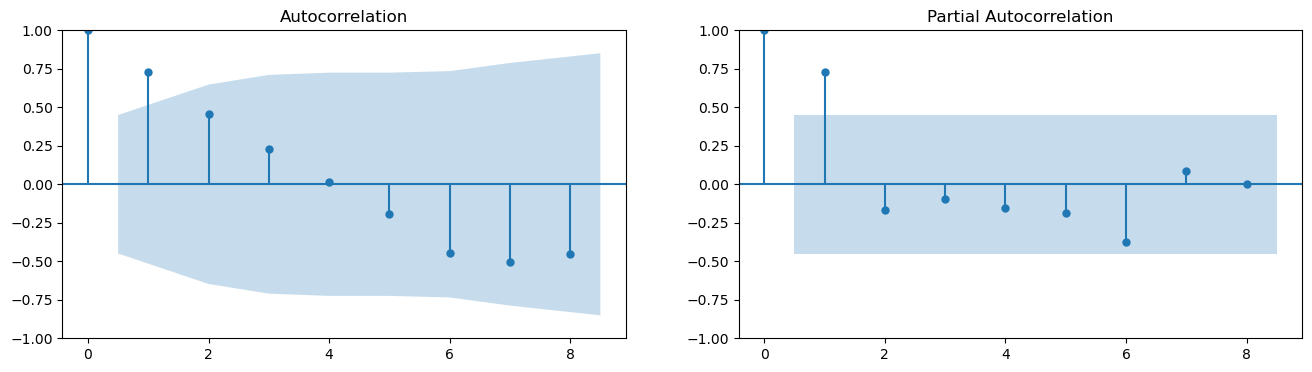

Using optimal parameters: p=0, d=3, q=2
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                   19
Model:                 ARIMA(0, 3, 2)   Log Likelihood                 -85.137
Date:                Mon, 30 Dec 2024   AIC                            176.274
Time:                        21:06:25   BIC                            178.591
Sample:                    01-31-2021   HQIC                           176.392
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.6822      5.783     -0.291      0.771     -13.016       9.652
ma.L2          0.6863      3.830      0.179      0.858      -6.820       8.192
sigma2      

c:\Users\valra\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Ploting ACF and PACF to find optimal parameters for ARIMA model
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
max_lags = min(8, len(train['Close']) // 2 - 1)
sm.graphics.tsa.plot_acf(train['Close'], lags=max_lags, ax=axes[0])
sm.graphics.tsa.plot_pacf(train['Close'], lags=max_lags, ax=axes[1])
plt.show()

print(f'Using optimal parameters: p={best_pdq[0]}, d={best_pdq[1]}, q={best_pdq[2]}')
model = ARIMA(train['Close'], order=best_pdq)
results = model.fit()

print(results.summary())

# Forecasting

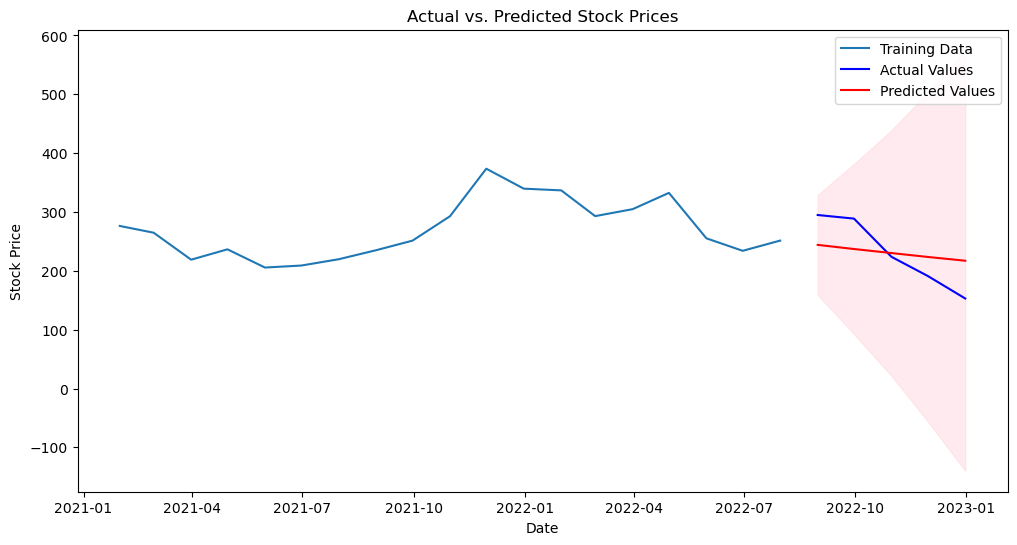

In [42]:
forecast = results.get_forecast(steps=len(test))
forecast_index = test.index
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the actual vs. predicted values for the test dataset
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual Values', color='blue')
plt.plot(forecast_index, predicted_mean, label='Predicted Values', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

# Model Evaluation

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae = mean_absolute_error(test['Close'], predicted_mean)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test['Close'], predicted_mean)
print(f'Mean Squared Error (MSE): {mse}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Walk-forward validation
history = [x for x in train[('Close', 'TSLA')]]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=best_pdq)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[('Close', 'TSLA')].iloc[t])

# Performance metrics for walk-forward validation
mae_wfv = mean_absolute_error(test['Close'], predictions)
mse_wfv = mean_squared_error(test['Close'], predictions)
rmse_wfv = math.sqrt(mse_wfv)

print(f'Walk-Forward Validation MAE: {mae_wfv}')
print(f'Walk-Forward Validation MSE: {mse_wfv}')
print(f'Walk-Forward Validation RMSE: {rmse_wfv}')

Mean Absolute Error (MAE): 41.07502492549332
Mean Squared Error (MSE): 2091.055235541542
Root Mean Squared Error (RMSE): 45.72805742147311
Walk-Forward Validation MAE: 34.96583412728855
Walk-Forward Validation MSE: 1707.507728342353
Walk-Forward Validation RMSE: 41.32200053654655


c:\Users\valra\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


# Visualization

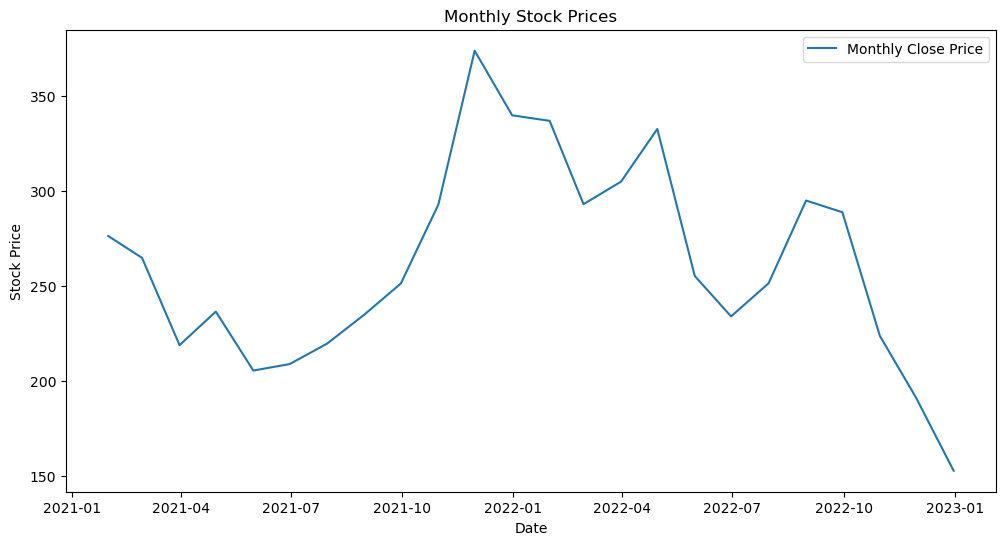

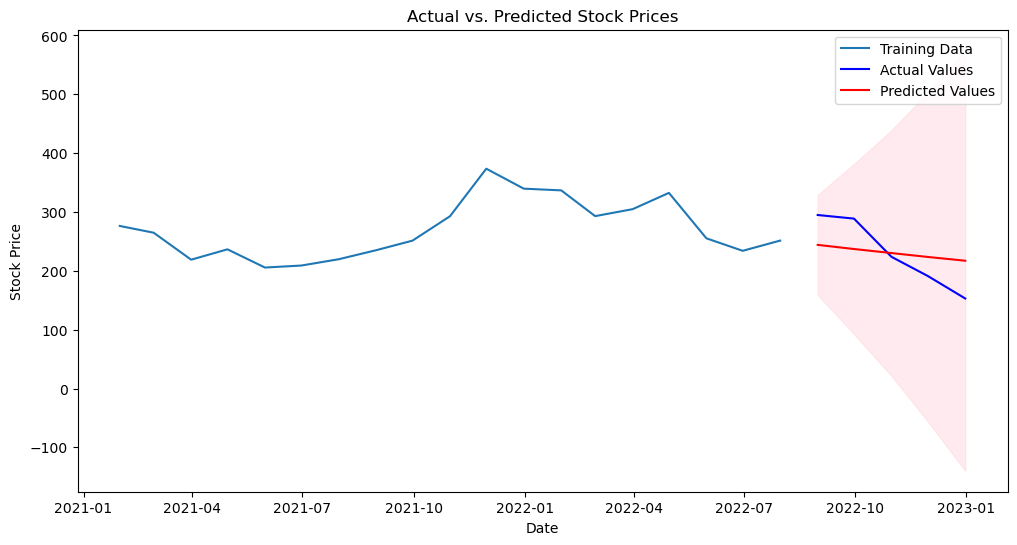

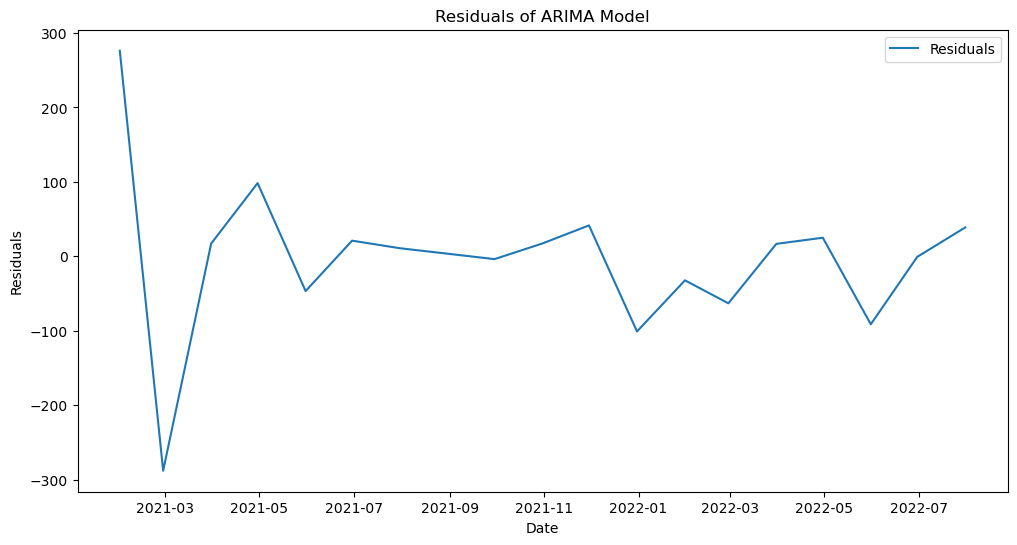

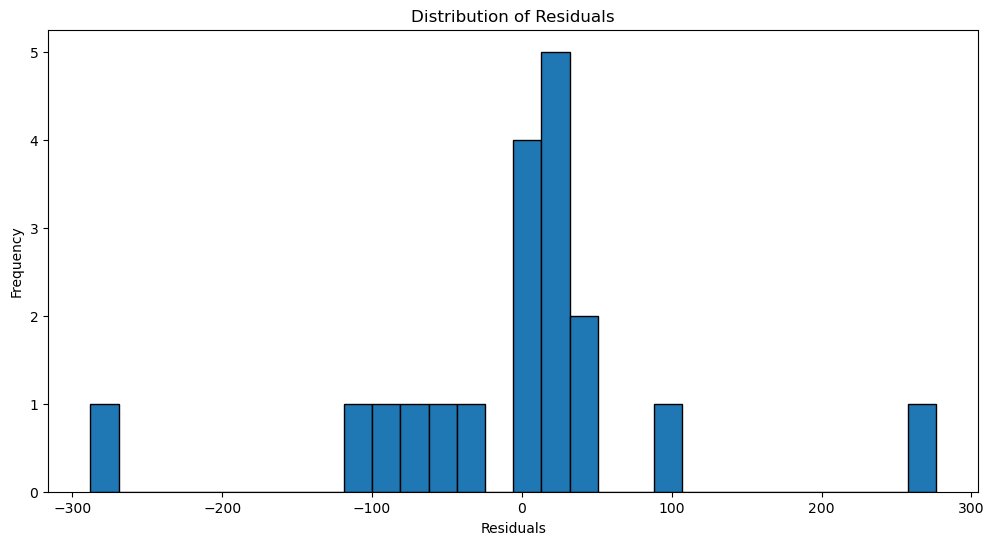

Residuals should ideally be randomly distributed around zero. If there are patterns in the residuals, it suggests that the model may not have captured all the information in the data.


In [44]:
# Time series data
plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index, data_monthly['Close'], label='Monthly Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Monthly Stock Prices')
plt.legend()
plt.show()

# Forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual Values', color='blue')
plt.plot(forecast_index, predicted_mean, label='Predicted Values', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

# Residuals
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of ARIMA Model')
plt.legend()
plt.show()

# Residuals distribution
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

print("Residuals should ideally be randomly distributed around zero. If there are patterns in the residuals, it suggests that the model may not have captured all the information in the data.")